In [11]:
install.packages("EnvStats")
install.packages("outliers")

package 'outliers' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Gabriel\AppData\Local\Temp\Rtmp84eKsa\downloaded_packages


In [1]:
temp1 <- tempfile()
download.file("https://github.com/Galeforse/DST-Assessment-02/raw/main/Data/1_percent_data.csv.gz",temp1)
conndata <- (read.csv(gzfile(temp1)))

In [2]:
head(conndata)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,,NA,NA,NA,REJ,0,Sr,1,48,1,40
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,,NA,NA,NA,S0,0,S,1,48,0,0
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40


In [3]:
summary(conndata)

       ts              orig_ip            orig_port       resp_ip         
 Min.   :1.332e+09   Length:226943      Min.   :    3   Length:226943     
 1st Qu.:1.332e+09   Class :character   1st Qu.:35857   Class :character  
 Median :1.332e+09   Mode  :character   Median :44316   Mode  :character  
 Mean   :1.332e+09                      Mean   :42635                     
 3rd Qu.:1.332e+09                      3rd Qu.:54373                     
 Max.   :1.332e+09                      Max.   :65535                     
                                                                          
   resp_port        proto             service             duration      
 Min.   :    0   Length:226943      Length:226943      Min.   :   0.01  
 1st Qu.: 2111   Class :character   Class :character   1st Qu.:   0.01  
 Median :10115   Mode  :character   Mode  :character   Median :   0.02  
 Mean   :20391                                         Mean   :   1.47  
 3rd Qu.:37749                     

In [4]:
mtab0=data.frame(
    missingduration=is.na(conndata[,"duration"]),
    proto=conndata[,"proto"])
mtab=table(mtab0)
(apply(mtab,2,function(x)x/sum(x)))

,icmp,tcp,udp
FALSE,0.8683921,0.1649403,0.3135747
TRUE,0.1316079,0.8350597,0.6864253


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"98 y values <= 0 omitted from logarithmic plot"


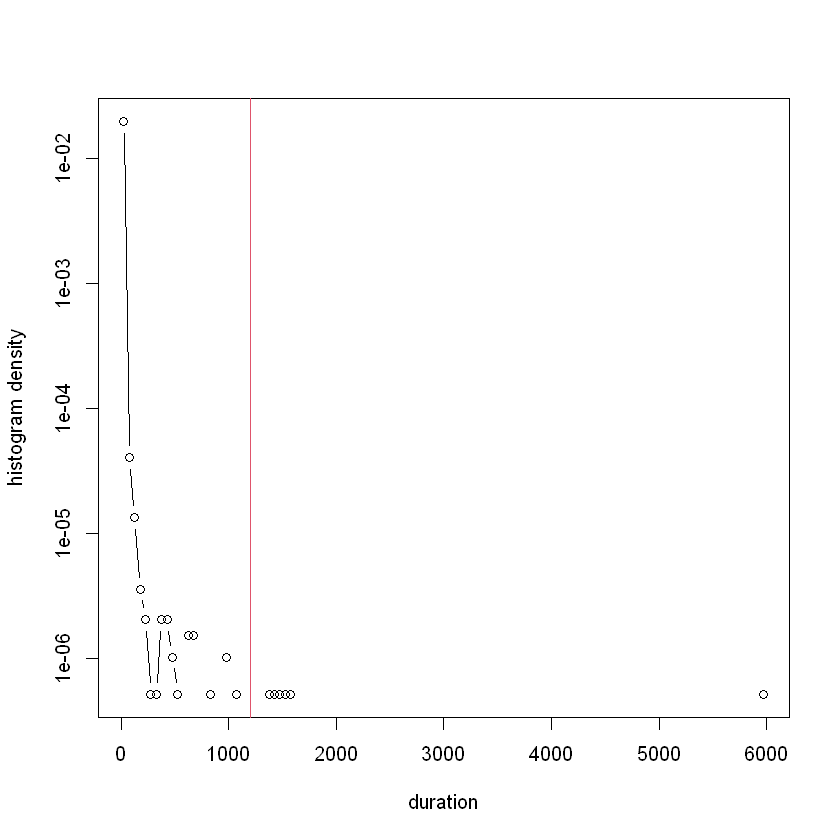

In [5]:
nbreaks=101 
thist=hist(conndata[,"duration"],breaks=nbreaks,plot=FALSE)

plot(thist$mids,thist$density,log="y",type="b",
     xlab="duration",ylab="histogram density")
threshold=1200 
abline(v=threshold,col=2) 

Here we see that there are some outliers. We can verify whether each point is an outlier with different statistical tests. We first want use Grubbs test but this relys on our data being approximately normally distrubted. But our data contains missing values so we use mean imputation to impute some data. 

In [ ]:
conndatamean=conndata
conndatamean[is.na(conndatamean[,"duration"]),
              "duration"]=
    mean(na.omit(conndatamean[,"duration"]))

tdata=conndatamean[conndatamean[,"duration"]<log(threshold),]
lm2=lm(duration~proto+service +ts +resp_ip,
       data=tdata)
ts1=summary(lm1)
ts2=summary(lm2)

Now we have imputed data we can test for normality by using a variety of methods. First we try a density plot to allow us to make a visual judgement.

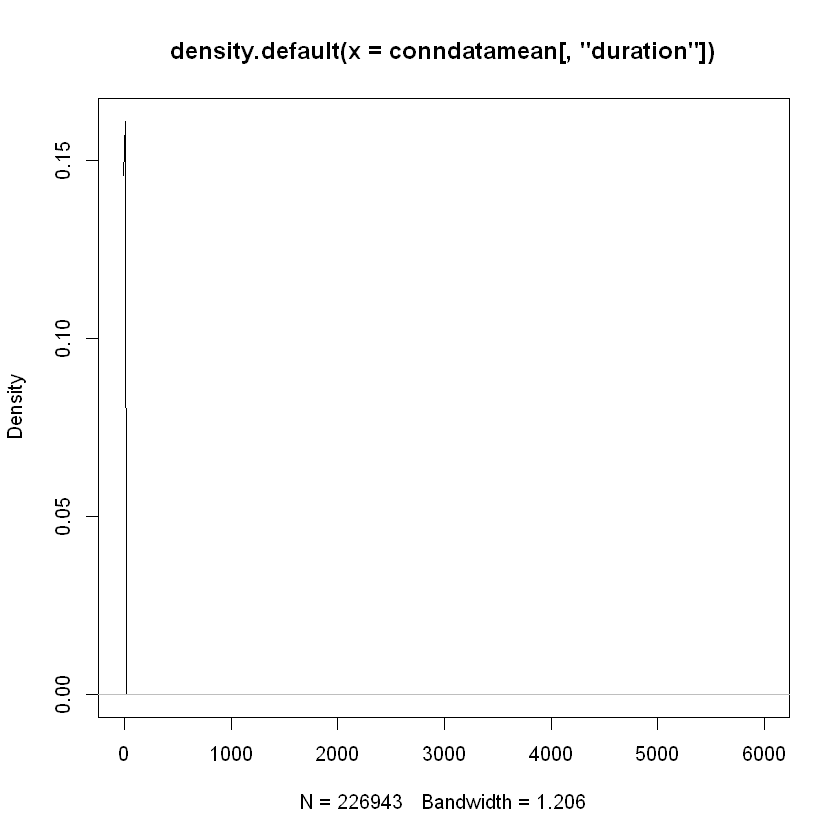

In [9]:
plot(density(conndatamean[,"duration"]))

Then, more formally, we can test using Shapiro-Wilk test via the following:

In [ ]:
shapiro.test(conndatamean$value)


In [ ]:
#I hope this is noramlly distrubuted otherwise i dont know what 
#to do lmao


The Grubbs test detects one outlier at a time (highest or lowest value), so the null and alternative hypotheses are as follows:

H_0: The highest value is not an outlier
H_1: The highest value is an outlier


In [12]:
library(outliers)
test <- grubbs.test(conndata[,"duration"])
test


	Grubbs test for one outlier

data:  conndata[, "duration"]
G = 157.45858, U = 0.36486, p-value < 2.2e-16
alternative hypothesis: highest value 5993.18 is an outlier


This comfirms what we saw visually in the histogram above.

Grubbs test can only test the highest or lowest value so we can use Rosner's test since it is designed to detect several outliers at once and it is designed to avoid the problem of 'masking', which is where  an outlier that is close in value to another outlier can go undetected.

In [14]:
library(EnvStats)
test <- rosnerTest(conndata[,"duration"], k = 5)
test

package 'EnvStats' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Gabriel\AppData\Local\Temp\Rtmp84eKsa\downloaded_packages



Attaching package: 'EnvStats'


The following objects are masked from 'package:stats':

    predict, predict.lm


The following object is masked from 'package:base':

    print.default


Warning message in rosnerTest(conndata[, "duration"], k = 5):
"187905 observations with NA/NaN/Inf in 'x' removed."


$distribution
[1] "Normal"

$statistic
      R.1       R.2       R.3       R.4       R.5 
157.45858  68.30291  70.85079  72.32054  75.20810 

$sample.size
[1] 39038

$parameters
k 
5 

$alpha
[1] 0.05

$crit.value
lambda.1 lambda.2 lambda.3 lambda.4 lambda.5 
4.842013 4.842008 4.842003 4.841998 4.841993 

$n.outliers
[1] 5

$alternative
[1] "Up to 5 observations are not\n                                 from the same Distribution."

$method
[1] "Rosner's Test for Outliers"

$data
    [1]    0.030000    0.010000    0.010000    0.010000    0.200000    0.060000
    [7]    0.110000    1.130000    0.270000    0.010000    0.040000    0.110000
   [13]    0.010000    0.030000    0.110000    0.420000    0.020000    0.010000
   [19]    0.250000    0.350000    0.020000    0.010000    0.010000    0.270000
   [25]    0.040000    0.010000    0.010000    2.950000    0.030000    0.030000
   [31]    0.030000    0.030000    0.030000    0.550000    0.010000    0.010000
   [37]    0.260000    0.020000    

In [8]:
daybreak=1331960000.0
conndata[,"day"]=0 + (conndata[,"ts"]>daybreak)
conndata[,"logduration"]=log(conndata[,"duration"])
lm1=lm(logduration~proto+service +ts +day,
       data=conndata[conndata[,"duration"]<1200,])
summary(lm1)


Call:
lm(formula = logduration ~ proto + service + ts + day, data = conndata[conndata[, 
    "duration"] < 1200, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-6.7122 -1.2961 -0.6053  0.7149 10.2256 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -4.289e+03  1.148e+03  -3.737 0.000187 ***
prototcp        -3.098e+00  4.208e-02 -73.616  < 2e-16 ***
protoudp         1.609e+00  1.535e-01  10.481  < 2e-16 ***
servicedhcp     -1.118e+00  9.475e-01  -1.180 0.237989    
servicedns      -3.526e-01  1.619e-01  -2.179 0.029361 *  
serviceftp       5.373e+00  3.065e-01  17.532  < 2e-16 ***
serviceftp-data -1.041e+00  4.889e-01  -2.129 0.033263 *  
servicehttp      3.166e-01  2.746e-02  11.529  < 2e-16 ***
servicesmtp      8.030e-02  9.360e-01   0.086 0.931629    
servicessh       4.047e+00  2.597e-01  15.581  < 2e-16 ***
servicessl       1.690e+00  7.200e-02  23.473  < 2e-16 ***
ts               3.220e-06  8.618e-07   3.737 0.000187 ***
day    

In [ ]:
# Indicator for missings
x1_miss_ind <- is.na(x1)
x2_miss_ind <- is.na(x2)
x3_miss_ind <- is.na(x3)

# Density of observed data
plot(density(conndata['duration'][x1_miss_ind == FALSE]),
     lwd = 2, 
     main = "Density Pre and Post Mean Imputation",
     xlab = "Duration")
 
# Density of observed & imputed data
points(density(conndatamean['duration']), 
       lwd = 2, 
       type = "l", 
       col = "red")
 
# Legend
legend("topleft",
       c("Before Imputation", "After Imputation"),
       lty = 1,
       lwd = 2,
       col = c("black", "red"))

In [ ]:
round(summary(conndata['duration'][x1_miss_ind == FALSE]), 2)
round(summary(conndata['duration']), 2)

Here we hope to see that the mean is the same as it should be but our IQR's have changed in such a way indicating a large bias.

Now we use the "Hmisc" data analysis package. Hmisc is useful for many things but its 'aregImpute' function allows mean imputation using aditive regression or bootstrapping.

In [ ]:
install.packages("Hmisc")
library(Hmisc)

impute_arg<- aregImpute(~logduration~proto+service +ts +id.resp_p+day, data=conndatamean, n.impute = 5)
impute_arg